# 닮은 꼴 사진 찾기

In [1]:
import os
import face_recognition
import numpy as np 
import matplotlib.pyplot as plt
from collections import OrderedDict
from PIL import Image
from glob import glob
from tqdm import tqdm

In [2]:
def get_cropped_face(image_path):
    # 이미지 경로를 통해 이미지를 불러오고
    image = face_recognition.load_image_file(image_path)
    # 이미지를 넣어서 얼굴 영역을 검출
    face_location = face_recognition.face_locations(image)
    # 얼굴영역의 위치가 검출되면 그 위치값을 기반으로 얼굴을 자름
    if len(face_location) >0:
        a, b , c, d = face_location[0]
        cropped_face = image[a:c, d:b, :]
        # 자른 얼굴을 리턴으로 내보냄
        return cropped_face
    else:
        return []

In [3]:
# 얼굴 임베딩
# 얼굴 영역 이미지를 넣어 얼굴 임베딩 값을 구함
def get_face_embedding(face_image):
    return face_recognition.face_encodings(face_image)

In [4]:
# 임베딩 딕셔너리
def get_face_embedding_dict(dir_path, embedding_dict):
    file_list =os.listdir(dir_path)  
    file_name = file_list[0].split('_')[0]
    
    for file in tqdm(file_list):
        img_path = os.path.join(dir_path, file)
        face = get_cropped_face(img_path)
        if len(face) ==0:
            continue
        embedding = get_face_embedding(face)
        if len(embedding) > 0:
            embedding_dict.setdefault(file_name, []).append((embedding[0], file))
    return embedding_dict


In [9]:
def get_face_embedding_dict(images_path):
    # 임베딩 값을 저장할 딕셔너리 생성
    embedding_dict = dict()
    # glob으로 전체 모든 이미지 경로를 불러옴
    file_path_list = glob(images_path)
    # 전체 이미지에서 basename만 불러오고 [이름 , 확장자] 형태로 분리 
    # 가지고 있는 이미지파일의 이름은 이름.확장자로 되어있음
    person_name_list = [ os.path.splitext(os.path.basename(file))[0] for file in file_path_list ]
    
    # 이미지에서 얼굴을 잘라내고 임베딩해서 딕션너리로 만들기
    for file, name in tqdm(zip(file_path_list, person_name_list)):
        face = get_cropped_face(file)
        # 얼굴을 못찾았으면 다음걸로 넘어가자
        if len(face) == 0:
            continue
        # 찾았다면 임베딩하자
        embedding = get_face_embedding(face)
        # 얼굴이 하나겠지만 하나 이상이면
        if len(embedding) > 0:
            # {"key" : [(embedding, 저장된 경로)]}
            embedding_dict.setdefault(name, []).append((embedding[0], file))
    return embedding_dict  

In [6]:
def get_distance(embed_dict, name1_array, name2):
    # 거리를 리스트로 만든이유는 똑같은 사람의 사진이 여러 장 있을 경우를 대비
    distance = []
    for i in embed_dict[name2]:
        # {"key" : [(embedding, 저장된 경로)]}
        dis = np.linalg.norm(name1_array - i[0], ord=2)
        distance.append(dis)
    return distance

In [17]:
def similar_picture(input_image_path, embedding_dict):
    # input_image 를 크롭하고 임베딩하기
    _input_image_face = get_cropped_face(input_image_path)
    _input_image_embedding = get_face_embedding(_input_image_face)
    
    # 비교대상 전체 불러와서 비교
    names = list(embedding_dict.keys())
    distance_dict = OrderedDict()
    for name in names:
        # 거리 구하기 (임베딩 dict, 인풋이미지 임베딩, 이름(key))
        distance = get_distance(embedding_dict, _input_image_embedding, name)
        # 거리가 가장 가까운
        min_value = min(distance)
        # 같은 사람이 여러장 있을 경우를 대비한 것
        index = distance.index(min_value)
        distance_dict[name] = (min_value, index)
    # 전체 사진 중에 가장 닮은 꼴 사진 불러오기
    min_distance = tuple(distance_dict.values())
    # 거리 값만 추출
    min_distance2 = [ dis for dis, _ in min_distance ]
    # 가장 거리가 가까운 이미지의 위치
    idx = min_distance2.index(min(min_distance2))
    
    # 골라진 사진
    picked =  tuple(distance_dict.keys())[idx]
    idx2 = distance_dict[picked][1]
    
    sim_img_path = embedding_dict[picked][idx2][1]
    get_face = get_cropped_face(sim_img_path)
    ###################시각화#######################
    fig = plt.figure(figsize=(20,15))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)
    
    ax1.set_title('Your Face')
    ax2.set_title('Similar Face')
    
    # 축 눈금 지우기
    ax1.axes.get_xaxis().set_visible(False)
    ax1.axes.get_yaxis().set_visible(False)
    ax2.axes.get_xaxis().set_visible(False)
    ax2.axes.get_yaxis().set_visible(False)

    ax1.imshow(_input_image_face)
    ax2.imshow(get_face)

    plt.show()

In [13]:
# 사진이 많을 수록 시간이 좀 걸리네요
embed_dict = get_face_embedding_dict("./images/*/*")

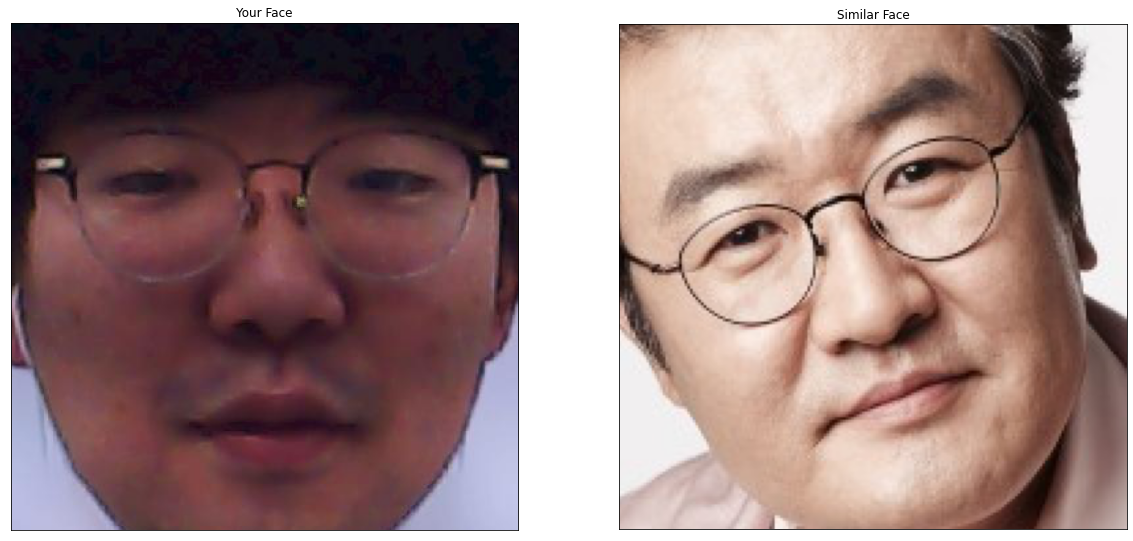

In [18]:
# 띠용 이분 누구죠?
similar_picture("./image.jpg", embed_dict)